### Importing Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, random_split, Dataset, WeightedRandomSampler
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import cv2

### Setting Random Seed for Reproducibility

In [2]:
# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Calling set_seed
set_seed(42)

### Device Configuration and Dataset Setup

In [3]:
# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset paths
DATA_DIR = '/kaggle/input/kermany2018/OCT2017 ' 

TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Define class names
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
num_classes = len(classes)

Using device: cuda:0


### Preprocessing Function: CLAHE

In [4]:
# Preprocessing function for CLAHE
def apply_clahe(img):
    img_np = np.array(img)
    if len(img_np.shape) == 3:  # RGB image
        img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    else:  # Already grayscale
        img_gray = img_np
        
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray.astype(np.uint8))
    
    # Convert back to PIL image
    return Image.fromarray(img_clahe)

### Preprocessing Function: Background Noise Removal

In [5]:
# Preprocessing function for removing background noise
def remove_background_noise(img):
    img_np = np.array(img)
    if len(img_np.shape) == 3:  # RGB image
        img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    else: 
        img_gray = img_np
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    # Threshold to remove background noise
    _, thresh = cv2.threshold(blurred, 20, 255, cv2.THRESH_TOZERO)
    
    # Convert back to PIL image
    return Image.fromarray(thresh)

### Preprocessing Function: Edge Enhancement

In [6]:
# Preprocessing function for edge enhancement
def enhance_edges(img):
    """Enhance edges using unsharp masking"""
    img_np = np.array(img)
    if len(img_np.shape) == 3:  # RGB image
        img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    else:  # Already grayscale
        img_gray = img_np
    
    # Apply unsharp masking
    gaussian = cv2.GaussianBlur(img_gray, (0, 0), 3.0)
    unsharp_image = cv2.addWeighted(img_gray, 1.5, gaussian, -0.5, 0)
    
    # Convert back to PIL image
    return Image.fromarray(unsharp_image)

### Dataset Class: OCTDataset with Preprocessing

In [7]:
# Dataset class with preprocessing
class OCTDataset(Dataset):
    def __init__(self, root_dir, transform=None, preprocess=True):
        self.root_dir = root_dir
        self.transform = transform
        self.preprocess = preprocess
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}
        
        # Load all image paths and labels
        for class_name in classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: Class directory {class_dir} not found!")
                continue
                
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.jpeg', '.jpg', '.png')):
                    img_path = os.path.join(class_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])
        
        # Verify dataset is not empty
        if len(self.image_paths) == 0:
            raise ValueError(f"No images found in {root_dir}. Please check the directory path.")
    
    def preprocess_image(self, image):
        # Convert to grayscale
        if image.mode != 'L':
            image = image.convert('L')
        
        # Remove background noise
        image = remove_background_noise(image)
        
        # Apply CLAHE for contrast enhancement
        image = apply_clahe(image)
        
        # Enhance edges
        image = enhance_edges(image)
        
        return image
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        # Apply preprocessing
        if self.preprocess:
            image = self.preprocess_image(image)
            # Convert back to RGB
            if image.mode == 'L':
                image = Image.merge('RGB', (image, image, image))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

### Data Transformations for Training and Evaluation

In [8]:
# Create data transformations
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),          
    transforms.Resize((224, 224)),                         
    transforms.RandomHorizontalFlip(),                     
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),                                 
    transforms.Normalize(mean=[0.5], std=[0.5])            
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),     
    transforms.Resize((224, 224)),                   
    transforms.ToTensor(),                           
    transforms.Normalize(mean=[0.5], std=[0.5])      
])

### Creating Dataset Instances with Transformations

In [9]:
# Create dataset instances
train_dataset = OCTDataset(TRAIN_DIR, transform=train_transform, preprocess=True)
val_dataset = OCTDataset(VAL_DIR, transform=val_test_transform, preprocess=True)
test_dataset = OCTDataset(TEST_DIR, transform=val_test_transform, preprocess=True)

### Class Distribution Analysis and Visualization

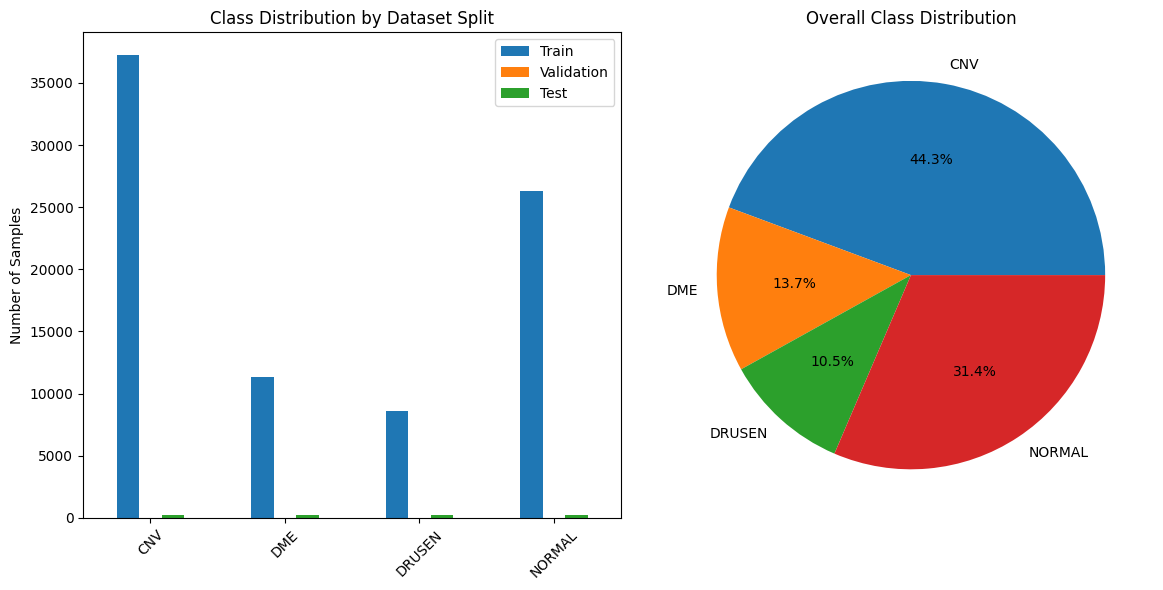

Class Distribution:
        Train  Validation  Test  Total  Percentage
CNV     37205           8   242  37455       44.33
DME     11348           8   242  11598       13.73
DRUSEN   8616           8   242   8866       10.49
NORMAL  26315           8   242  26565       31.44


In [10]:
# Class distribution analysis
def analyze_class_distribution():
    # Function to count classes
    def count_class_samples(dataset_dir):
        counts = {class_name: 0 for class_name in classes}
        for class_name in classes:
            class_dir = os.path.join(dataset_dir, class_name)
            if os.path.exists(class_dir):
                counts[class_name] = len([f for f in os.listdir(class_dir) 
                                         if f.endswith('.jpeg')])
        return counts
    
    # Count samples in each split
    train_counts = count_class_samples(TRAIN_DIR)
    val_counts = count_class_samples(VAL_DIR)
    test_counts = count_class_samples(TEST_DIR)
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Train': train_counts,
        'Validation': val_counts,
        'Test': test_counts
    })
    
    # Add total column
    df['Total'] = df.sum(axis=1)
    
    # Add percentage columns
    total_samples = df['Total'].sum()
    df['Percentage'] = (df['Total'] / total_samples * 100).round(2)
    
    # Plot distribution
    plt.figure(figsize=(12, 6))
    
    # Class distribution
    plt.subplot(1, 2, 1)
    df[['Train', 'Validation', 'Test']].plot(kind='bar', ax=plt.gca())
    plt.title('Class Distribution by Dataset Split')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    # Percentage distribution
    plt.subplot(1, 2, 2)
    plt.pie(df['Total'], labels=df.index, autopct='%1.1f%%')
    plt.title('Overall Class Distribution')
    
    plt.tight_layout()
    plt.savefig('class_distribution.png')
    plt.show()
    
    # Print table
    print("Class Distribution:")

    print(df)
    
    return df

# Analyze class distribution
class_dist = analyze_class_distribution()

### Calculating Class Weights for Imbalanced Data

In [11]:
def calculate_class_weights(class_distribution_df):
    # Get sample counts
    class_counts = class_distribution_df['Total'].to_dict()
    total_samples = sum(class_counts.values())
    
    # Calculate weights: n_samples / (n_classes * n_samples_for_class)
    num_classes = len(class_counts)
    class_weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}
    
    # Convert to tensor for the loss function
    weights_tensor = torch.FloatTensor([class_weights[cls] for cls in classes]).to(device)
    
    return class_weights, weights_tensor

# Calculate class weights
class_weights_dict, weights_tensor = calculate_class_weights(class_dist)

In [12]:
# If validation set is too small, create a new split from training data
MIN_VAL_SIZE = 500  # Minimum size for validation set
if len(val_dataset) < MIN_VAL_SIZE and len(train_dataset) > MIN_VAL_SIZE * 4:
    print(f"Validation set too small ({len(val_dataset)} samples). Creating new train/val split...")
    
    # Combine original train and val datasets
    combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
    
    # Calculate split sizes
    total_size = len(combined_dataset)
    val_size = int(0.2 * total_size)  # 20% for validation
    train_size = total_size - val_size
    
    # Create new splits
    train_dataset, val_dataset = random_split(
        combined_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    print(f"New train/val split: {len(train_dataset)} train, {len(val_dataset)} validation samples")


Validation set too small (32 samples). Creating new train/val split...
New train/val split: 66813 train, 16703 validation samples


### Creating Weighted Sampler for Class Imbalance

In [13]:
def create_weighted_sampler(dataset, class_weights):
    if isinstance(dataset, torch.utils.data.Subset):
        # For datasets created with random_split
        if isinstance(dataset.dataset, torch.utils.data.ConcatDataset):
            # Handle case when dataset.dataset is a ConcatDataset
            labels = []
            for idx in dataset.indices:
                dataset_idx = 0
                sample_idx = idx
                for d in dataset.dataset.datasets:
                    if sample_idx < len(d):
                        break
                    sample_idx -= len(d)
                    dataset_idx += 1
                if dataset_idx < len(dataset.dataset.datasets):
                    d = dataset.dataset.datasets[dataset_idx]
                    labels.append(d.labels[sample_idx])
        else:
            # Regular Subset
            labels = [dataset.dataset.labels[i] for i in dataset.indices]
    else:
        # For original datasets
        if isinstance(dataset, torch.utils.data.ConcatDataset):
            # Handle concatenated datasets
            labels = []
            for d in dataset.datasets:
                labels.extend(d.labels)
        else:
            # Regular Dataset
            labels = dataset.labels
        
    # Assign weights to each sample based on its class
    weights = [class_weights[classes[label]] for label in labels]
    sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True)
    return sampler

### Creating DataLoaders with Weighted Sampler

In [14]:
def create_data_loaders(train_dataset, val_dataset, test_dataset, class_weights, batch_size=32):
    # Create weighted sampler for training data
    train_sampler = create_weighted_sampler(train_dataset, class_weights)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        sampler=train_sampler,  # Using weighted sampler
        num_workers=4
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4
    )
    
    return train_loader, val_loader, test_loader

### Creating DataLoaders for Training, Validation, and Testing

In [15]:
# Create data loaders
batch_size = 32
train_loader, val_loader, test_loader = create_data_loaders(
    train_dataset, val_dataset, test_dataset, class_weights_dict, batch_size
)

### Printing Dataset Sizes

In [16]:
# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 66813
Validation dataset size: 16703
Test dataset size: 968


# CNN Model for OCT Image Classification

In [17]:
# CNN model
class OCT_CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(OCT_CNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  
        )
        
        # Fourth convolutional block
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) 
        )
        
        # Fifth convolutional block
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 14x14 -> 7x7
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),  
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),  
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        # Apply convolutional blocks
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        # Apply fully connected layers
        x = self.fc(x)
        
        return x

### Initializing the OCT_CNN Model

In [18]:
# Initialize the model
model = OCT_CNN(num_classes=num_classes).to(device)
print(model)

OCT_CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNor

### Displaying Model Summary

In [19]:
from torchinfo import summary
summary(model, input_size=(1, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
OCT_CNN                                  [1, 4]                    --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         320
│    └─BatchNorm2d: 2-2                  [1, 32, 224, 224]         64
│    └─ReLU: 2-3                         [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 32, 112, 112]         --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-5                       [1, 64, 112, 112]         18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 112, 112]         128
│    └─ReLU: 2-7                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-8                    [1, 64, 56, 56]           --
├─Sequential: 1-3                        [1, 128, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 128, 56, 56]          73,856
│    

### Counting Trainable Parameters and Defining Optimizer

In [20]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr=1e-6
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Visualizing Preprocessing Steps on OCT Images

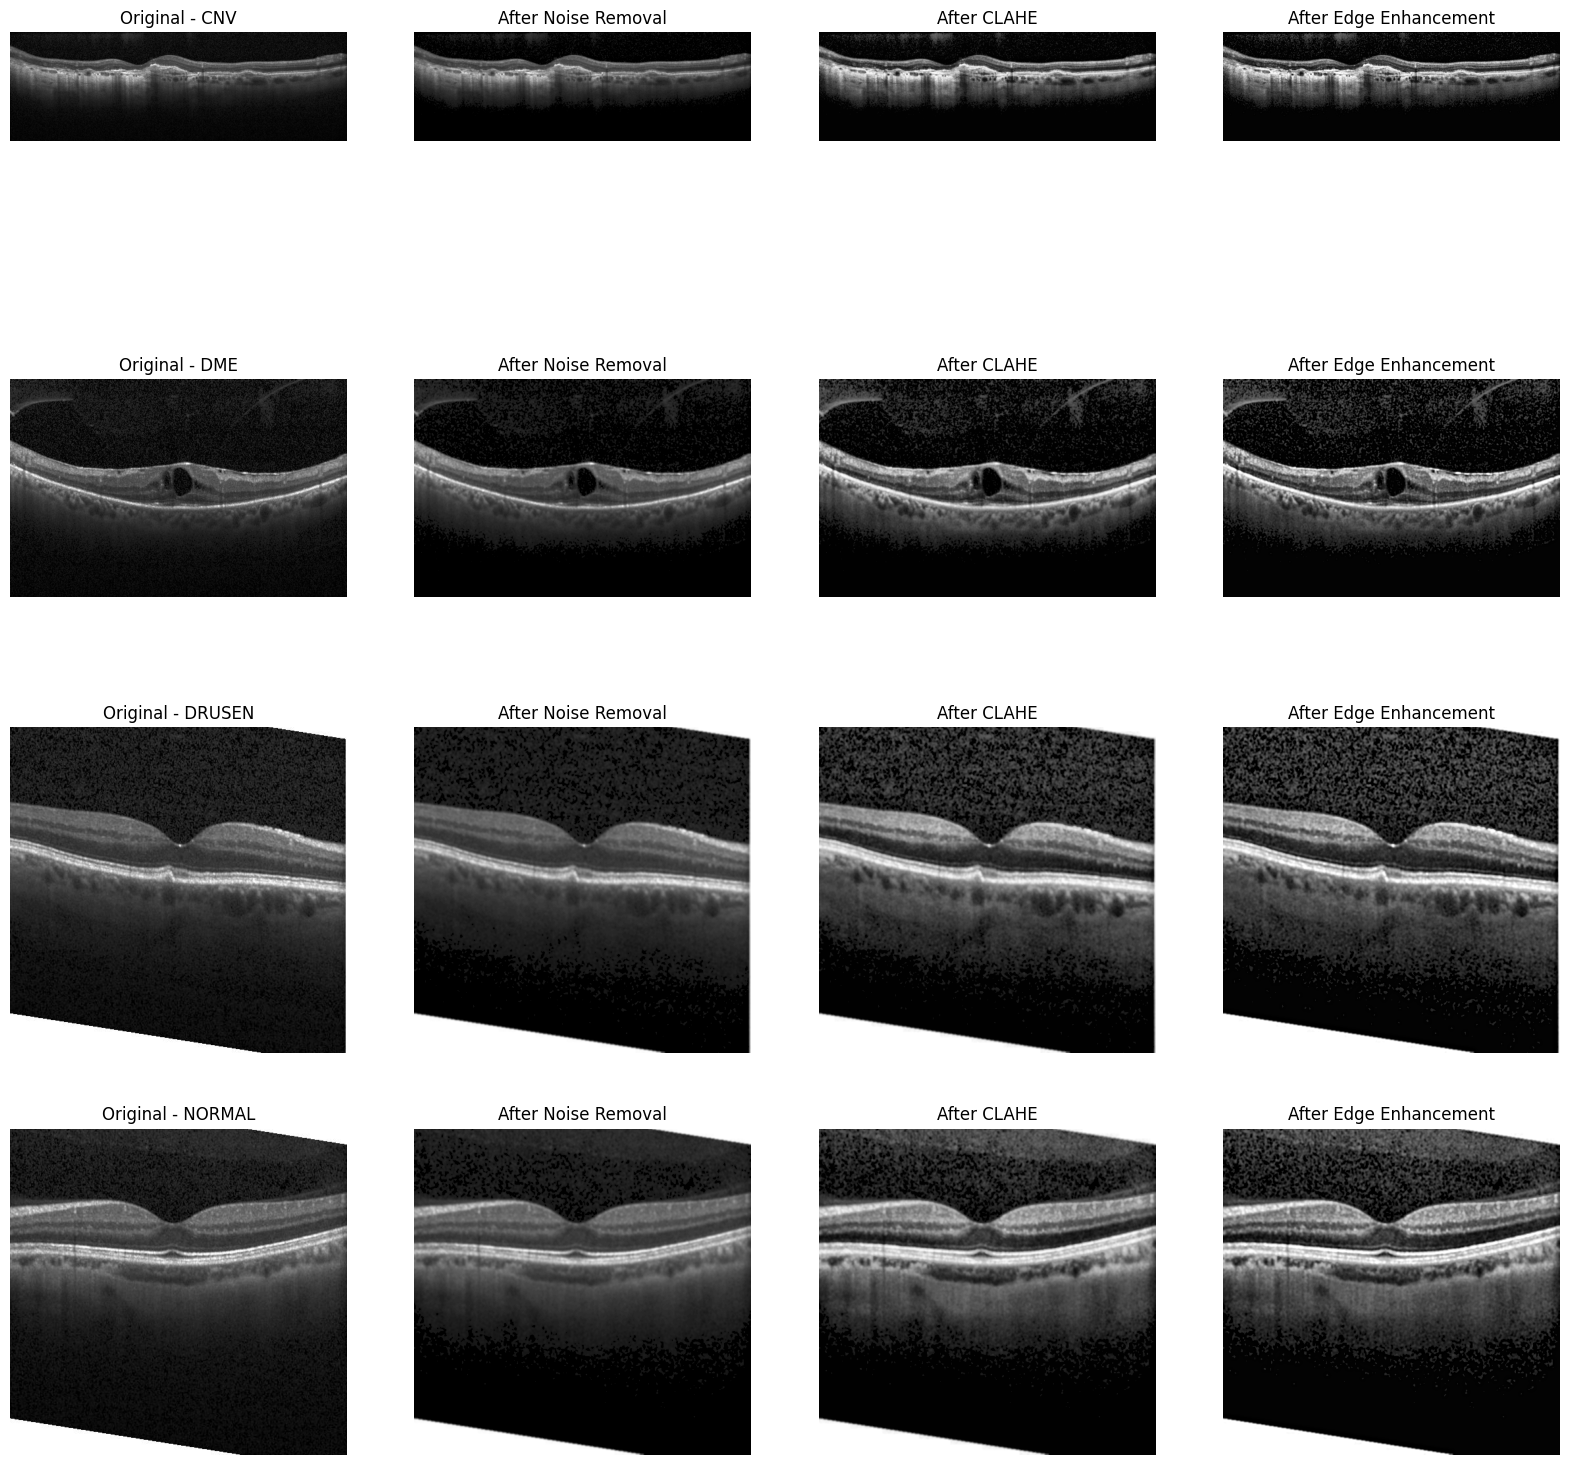

In [21]:
def visualize_preprocessing(dataset_dir):
    classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    num_classes = len(classes)
    
    fig, axes = plt.subplots(num_classes, 4, figsize=(20, num_classes*5))
    
    for i, class_name in enumerate(classes):
        # Get class directory
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Class directory {class_dir} not found!")
            continue
            
        # Get a random image from this class
        img_files = [f for f in os.listdir(class_dir) if f.endswith('.jpeg')]
        if not img_files:
            print(f"Warning: No images found in {class_dir}")
            continue
            
        img_file = np.random.choice(img_files)
        img_path = os.path.join(class_dir, img_file)
        
        # Original image
        img_orig = Image.open(img_path).convert('L')
        axes[i, 0].imshow(img_orig, cmap='gray')
        axes[i, 0].set_title(f"Original - {class_name}")
        axes[i, 0].axis('off')
        
        # After noise removal
        img_noise_removed = remove_background_noise(img_orig)
        axes[i, 1].imshow(img_noise_removed, cmap='gray')
        axes[i, 1].set_title("After Noise Removal")
        axes[i, 1].axis('off')
        
        # After CLAHE
        img_clahe = apply_clahe(img_noise_removed)
        axes[i, 2].imshow(img_clahe, cmap='gray')
        axes[i, 2].set_title("After CLAHE")
        axes[i, 2].axis('off')
        
        # After edge enhancement
        img_edges = enhance_edges(img_clahe)
        axes[i, 3].imshow(img_edges, cmap='gray')
        axes[i, 3].set_title("After Edge Enhancement")
        axes[i, 3].axis('off')
    
    plt.show()

# Visualizing preprocessing
train_dir = os.path.join('/kaggle/input/kermany2018/OCT2017 /train')
visualize_preprocessing(train_dir)

### Model Evaluation Function

In [22]:
# Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

### Training Function with Early Stopping

In [23]:
# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=70, patience=7):
    best_val_acc = 0.0
    best_val_loss = float('inf')
    training_stats = []
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            train_bar.set_postfix({'loss': loss.item(), 'acc': correct/total})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        # Validation phase
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        
        # Learning rate scheduler step
        scheduler.step(val_loss)
        
        # Print statistics
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Save best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_oct_model.pth')
            print(f"Saved new best model with validation loss: {best_val_loss:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
        
        # Save training stats
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': epoch_loss,
            'train_acc': epoch_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'lr': optimizer.param_groups[0]['lr']
        })
    
    # Load best model
    model.load_state_dict(torch.load('best_oct_model.pth'))
    return model, training_stats

# Train the model
model, training_stats = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, 
    num_epochs=70, patience=7
)

Epoch 1/70 [Train]: 100%|██████████| 2088/2088 [06:33<00:00,  5.30it/s, loss=0.54, acc=0.54]  


Epoch 1/70:
Train Loss: 0.8727, Train Acc: 0.5405
Val Loss: 0.5545, Val Acc: 0.7990
Saved new best model with validation loss: 0.5545


Epoch 2/70 [Train]: 100%|██████████| 2088/2088 [06:09<00:00,  5.66it/s, loss=0.469, acc=0.84]  


Epoch 2/70:
Train Loss: 0.3539, Train Acc: 0.8397
Val Loss: 0.4586, Val Acc: 0.8258
Saved new best model with validation loss: 0.4586


Epoch 3/70 [Train]: 100%|██████████| 2088/2088 [05:54<00:00,  5.90it/s, loss=0.267, acc=0.878] 


Epoch 3/70:
Train Loss: 0.2772, Train Acc: 0.8777
Val Loss: 0.3587, Val Acc: 0.8690
Saved new best model with validation loss: 0.3587


Epoch 4/70 [Train]: 100%|██████████| 2088/2088 [05:50<00:00,  5.95it/s, loss=0.232, acc=0.895] 


Epoch 4/70:
Train Loss: 0.2471, Train Acc: 0.8950
Val Loss: 0.2352, Val Acc: 0.9048
Saved new best model with validation loss: 0.2352


Epoch 5/70 [Train]: 100%|██████████| 2088/2088 [05:51<00:00,  5.93it/s, loss=0.0959, acc=0.907]


Epoch 5/70:
Train Loss: 0.2168, Train Acc: 0.9068
Val Loss: 0.2699, Val Acc: 0.8814


Epoch 6/70 [Train]: 100%|██████████| 2088/2088 [05:48<00:00,  5.99it/s, loss=0.381, acc=0.917] 


Epoch 6/70:
Train Loss: 0.1919, Train Acc: 0.9166
Val Loss: 0.2333, Val Acc: 0.9266
Saved new best model with validation loss: 0.2333


Epoch 7/70 [Train]: 100%|██████████| 2088/2088 [05:54<00:00,  5.89it/s, loss=0.272, acc=0.919]  


Epoch 7/70:
Train Loss: 0.1878, Train Acc: 0.9193
Val Loss: 0.2860, Val Acc: 0.8757


Epoch 8/70 [Train]: 100%|██████████| 2088/2088 [05:45<00:00,  6.04it/s, loss=0.123, acc=0.923]  


Epoch 8/70:
Train Loss: 0.1739, Train Acc: 0.9233
Val Loss: 0.2030, Val Acc: 0.9253
Saved new best model with validation loss: 0.2030


Epoch 9/70 [Train]: 100%|██████████| 2088/2088 [05:54<00:00,  5.90it/s, loss=0.0484, acc=0.925] 


Epoch 9/70:
Train Loss: 0.1669, Train Acc: 0.9251
Val Loss: 0.2474, Val Acc: 0.8905


Epoch 10/70 [Train]: 100%|██████████| 2088/2088 [05:56<00:00,  5.86it/s, loss=0.313, acc=0.93]   


Epoch 10/70:
Train Loss: 0.1593, Train Acc: 0.9304
Val Loss: 0.2228, Val Acc: 0.8896


Epoch 11/70 [Train]: 100%|██████████| 2088/2088 [05:54<00:00,  5.89it/s, loss=0.313, acc=0.934]  


Epoch 11/70:
Train Loss: 0.1483, Train Acc: 0.9345
Val Loss: 0.1752, Val Acc: 0.9310
Saved new best model with validation loss: 0.1752


Epoch 12/70 [Train]: 100%|██████████| 2088/2088 [05:54<00:00,  5.88it/s, loss=0.201, acc=0.936]  


Epoch 12/70:
Train Loss: 0.1398, Train Acc: 0.9363
Val Loss: 0.1903, Val Acc: 0.9281


Epoch 13/70 [Train]: 100%|██████████| 2088/2088 [05:48<00:00,  5.99it/s, loss=0.176, acc=0.939]  


Epoch 13/70:
Train Loss: 0.1385, Train Acc: 0.9386
Val Loss: 0.2440, Val Acc: 0.9040


Epoch 14/70 [Train]: 100%|██████████| 2088/2088 [05:45<00:00,  6.04it/s, loss=0.347, acc=0.939]  


Epoch 14/70:
Train Loss: 0.1343, Train Acc: 0.9393
Val Loss: 0.2013, Val Acc: 0.9062


Epoch 15/70 [Train]: 100%|██████████| 2088/2088 [05:46<00:00,  6.02it/s, loss=0.0808, acc=0.941] 


Epoch 15/70:
Train Loss: 0.1297, Train Acc: 0.9413
Val Loss: 0.1932, Val Acc: 0.9222


Epoch 16/70 [Train]: 100%|██████████| 2088/2088 [05:44<00:00,  6.06it/s, loss=0.0473, acc=0.95]  


Epoch 16/70:
Train Loss: 0.1053, Train Acc: 0.9504
Val Loss: 0.1513, Val Acc: 0.9381
Saved new best model with validation loss: 0.1513


Epoch 17/70 [Train]: 100%|██████████| 2088/2088 [05:46<00:00,  6.03it/s, loss=0.0363, acc=0.953] 


Epoch 17/70:
Train Loss: 0.0996, Train Acc: 0.9533
Val Loss: 0.1688, Val Acc: 0.9343


Epoch 18/70 [Train]: 100%|██████████| 2088/2088 [05:52<00:00,  5.93it/s, loss=0.0448, acc=0.955] 


Epoch 18/70:
Train Loss: 0.0946, Train Acc: 0.9549
Val Loss: 0.1782, Val Acc: 0.9207


Epoch 19/70 [Train]: 100%|██████████| 2088/2088 [05:50<00:00,  5.95it/s, loss=0.108, acc=0.955]  


Epoch 19/70:
Train Loss: 0.0956, Train Acc: 0.9550
Val Loss: 0.1508, Val Acc: 0.9391
Saved new best model with validation loss: 0.1508


Epoch 20/70 [Train]: 100%|██████████| 2088/2088 [05:49<00:00,  5.97it/s, loss=0.1, acc=0.958]    


Epoch 20/70:
Train Loss: 0.0877, Train Acc: 0.9577
Val Loss: 0.1444, Val Acc: 0.9385
Saved new best model with validation loss: 0.1444


Epoch 21/70 [Train]: 100%|██████████| 2088/2088 [05:54<00:00,  5.89it/s, loss=0.0845, acc=0.959] 


Epoch 21/70:
Train Loss: 0.0854, Train Acc: 0.9593
Val Loss: 0.1947, Val Acc: 0.9347


Epoch 22/70 [Train]: 100%|██████████| 2088/2088 [05:47<00:00,  6.01it/s, loss=0.00898, acc=0.96] 


Epoch 22/70:
Train Loss: 0.0845, Train Acc: 0.9598
Val Loss: 0.1605, Val Acc: 0.9404


Epoch 23/70 [Train]: 100%|██████████| 2088/2088 [06:10<00:00,  5.64it/s, loss=0.0491, acc=0.959] 


Epoch 23/70:
Train Loss: 0.0857, Train Acc: 0.9595
Val Loss: 0.1599, Val Acc: 0.9304


Epoch 24/70 [Train]: 100%|██████████| 2088/2088 [06:03<00:00,  5.75it/s, loss=0.0605, acc=0.961] 


Epoch 24/70:
Train Loss: 0.0780, Train Acc: 0.9614
Val Loss: 0.1505, Val Acc: 0.9404


Epoch 25/70 [Train]: 100%|██████████| 2088/2088 [05:55<00:00,  5.87it/s, loss=0.115, acc=0.967]   


Epoch 25/70:
Train Loss: 0.0668, Train Acc: 0.9673
Val Loss: 0.1402, Val Acc: 0.9429
Saved new best model with validation loss: 0.1402


Epoch 26/70 [Train]: 100%|██████████| 2088/2088 [05:51<00:00,  5.94it/s, loss=0.0357, acc=0.968] 


Epoch 26/70:
Train Loss: 0.0642, Train Acc: 0.9683
Val Loss: 0.1277, Val Acc: 0.9485
Saved new best model with validation loss: 0.1277


Epoch 27/70 [Train]: 100%|██████████| 2088/2088 [05:51<00:00,  5.94it/s, loss=0.0501, acc=0.969]  


Epoch 27/70:
Train Loss: 0.0614, Train Acc: 0.9687
Val Loss: 0.1461, Val Acc: 0.9390


Epoch 28/70 [Train]: 100%|██████████| 2088/2088 [05:54<00:00,  5.89it/s, loss=0.0901, acc=0.97]   


Epoch 28/70:
Train Loss: 0.0615, Train Acc: 0.9701
Val Loss: 0.1288, Val Acc: 0.9558


Epoch 29/70 [Train]: 100%|██████████| 2088/2088 [06:25<00:00,  5.41it/s, loss=0.0147, acc=0.971]  


Epoch 29/70:
Train Loss: 0.0589, Train Acc: 0.9708
Val Loss: 0.1306, Val Acc: 0.9594


Epoch 30/70 [Train]: 100%|██████████| 2088/2088 [06:13<00:00,  5.59it/s, loss=0.00449, acc=0.973] 


Epoch 30/70:
Train Loss: 0.0572, Train Acc: 0.9725
Val Loss: 0.1365, Val Acc: 0.9476


Epoch 31/70 [Train]: 100%|██████████| 2088/2088 [06:38<00:00,  5.23it/s, loss=0.0465, acc=0.974]  


Epoch 31/70:
Train Loss: 0.0532, Train Acc: 0.9741
Val Loss: 0.1338, Val Acc: 0.9517


Epoch 32/70 [Train]: 100%|██████████| 2088/2088 [06:42<00:00,  5.19it/s, loss=0.0349, acc=0.976]  


Epoch 32/70:
Train Loss: 0.0484, Train Acc: 0.9757
Val Loss: 0.1417, Val Acc: 0.9514


Epoch 33/70 [Train]: 100%|██████████| 2088/2088 [06:40<00:00,  5.22it/s, loss=0.0652, acc=0.975] 


Epoch 33/70:
Train Loss: 0.0494, Train Acc: 0.9753
Val Loss: 0.1281, Val Acc: 0.9532
Early stopping triggered after 33 epochs


/tmp/ipykernel_31/1571332403.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_oct_model.pth'))


### Function to Visualize Training Progress

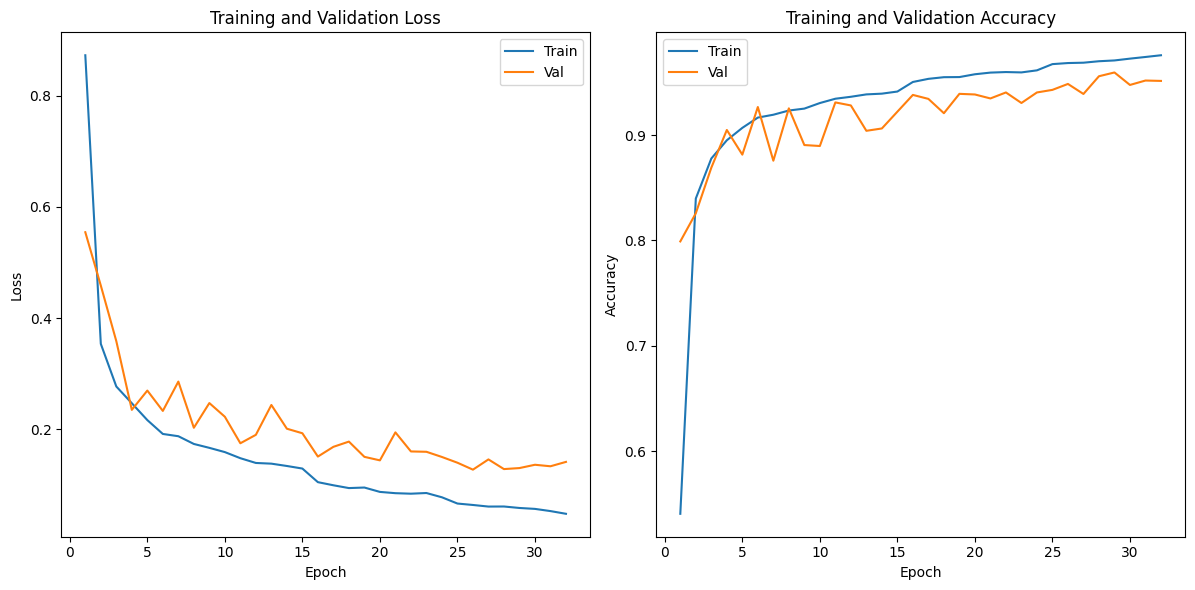

In [24]:
# Function to visualize training progress
def plot_training_stats(training_stats):
    stats_df = pd.DataFrame(training_stats)
    
    # Create a figure with 3 subplots
    plt.figure(figsize=(18, 6))
    
    # Plot training & validation loss
    plt.subplot(1, 3, 1)
    plt.plot(stats_df['epoch'], stats_df['train_loss'], label='Train')
    plt.plot(stats_df['epoch'], stats_df['val_loss'], label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot training & validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(stats_df['epoch'], stats_df['train_acc'], label='Train')
    plt.plot(stats_df['epoch'], stats_df['val_acc'], label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Plot training statistics
plot_training_stats(training_stats)

### Function to Test the Model and Generate Classification Repor

### Testing the model

In [25]:
# Function to test model and generate classification report
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate test accuracy
    test_acc = sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    plt.close()
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=classes)
    print("\nClassification Report:")
    print(report)
    
    return cm, report, test_acc

Testing: 100%|██████████| 31/31 [00:06<00:00,  4.98it/s]


Test Accuracy: 0.9979


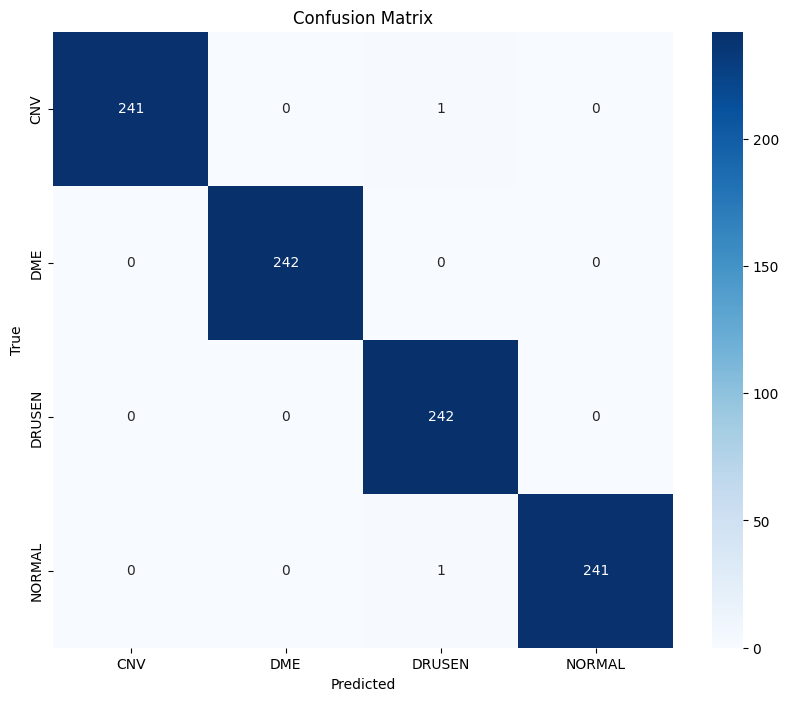


Classification Report:
              precision    recall  f1-score   support

         CNV       1.00      1.00      1.00       242
         DME       1.00      1.00      1.00       242
      DRUSEN       0.99      1.00      1.00       242
      NORMAL       1.00      1.00      1.00       242

    accuracy                           1.00       968
   macro avg       1.00      1.00      1.00       968
weighted avg       1.00      1.00      1.00       968



In [26]:
# Test the model
cm, report, test_acc = test_model(model, test_loader)